## Описание задачи

Имеющийся [датасет](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data) не предоставляет итоговые метки классов, но предоставляет долю аннотаторов, которые проставили тексту соответствующую метку, от общего числа аннотаторов для этого текста. Чтобы получить итоговую метку как индикатор, нам необходимо выбрать порог $t \in [0, 1]$, при сравнении с которым можно было бы однозначно определить метку следующим образом: $x<t \Rightarrow \text{negative label}, x \geq t \Rightarrow \text{positive label}$

Авторы kaggle competition предлагают использовать значение $t=0.5$, однако мы предполагаем, что существует меньшее значение $t$, начиная с которого можно было бы отнести текст к позитивному классу. Исследование в данном ноутбуке направлено на эмпирическую проверку этого предположения.

Методология:
1. Смотрим на распределение доли аннотаторов и определяем множество потенциальных порогов
2. Для каждого порога из п.1 делаем тестовое разбиение и проводим сравнительный анализ получившихся negative и positive labeled корпусов
3. Для дальнейшей работы выбираем такой минимальный порог, при котором различие в тональности текстов становится очевидным

---

## Подготовка данных и инструментов для исследования

Загрузка данных, удаление пропущенных значений и дубликатов

In [ ]:
from google.colab import userdata
import os

os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

100% 723M/723M [00:11<00:00, 76.7MB/s]
100% 723M/723M [00:11<00:00, 63.9MB/s]


In [ ]:
!unzip "jigsaw-unintended-bias-in-toxicity-classification.zip" -d "data"

Archive:  jigsaw-unintended-bias-in-toxicity-classification.zip
  inflating: data/all_data.csv       
  inflating: data/identity_individual_annotations.csv  
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/test_private_expanded.csv  
  inflating: data/test_public_expanded.csv  
  inflating: data/toxicity_individual_annotations.csv  
  inflating: data/train.csv          


In [ ]:
from IPython.display import display
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import re

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


tqdm.pandas()
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
df = pd.read_csv('data/train.csv', parse_dates=['created_date'], date_format='ISO8601').rename(columns={'target': 'toxicity'})

In [ ]:
df['comment_text'].duplicated().sum()

# Кол-во дублирующих текстов (https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data#:~:text=other_disability-,Note,-that%20the%20data)
# Оставим из них те, у кого больше аннотаторов

24051

In [ ]:
df = df.dropna(subset='comment_text').sort_values(by='toxicity_annotator_count', ascending=False).drop_duplicates(subset='comment_text', keep='first').reset_index(drop=True)
df.shape

(1780822, 45)

Посмотрим на распределение долей аннотаторов, посчитавших текст токсичным, и отметим на гистограмме потенциальные значения, по которым можно было бы бинаризовать признак 'toxicity' - места скачков в распределении

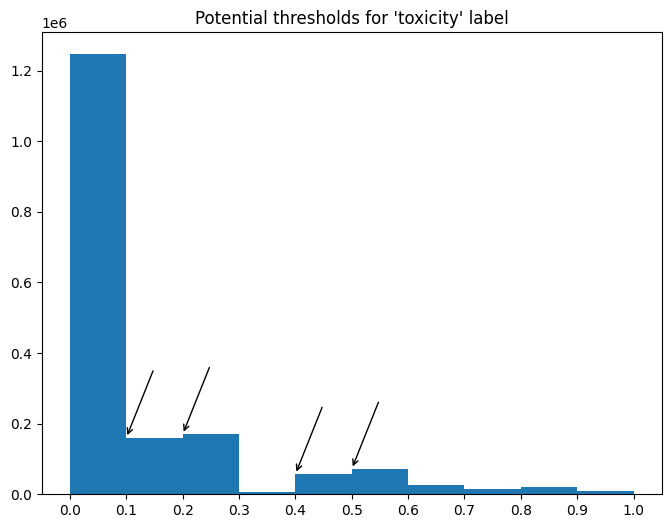

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

_, bins, patches = ax.hist(df['toxicity'], bins=10)

potential_thresholds = [0.1, 0.2, 0.4, 0.5]

for bin, patch in zip(bins, patches):
    for th in potential_thresholds:
        if abs(bin-th) < 1e-16:
            ax.annotate('', xy=(bin, patch.get_height()), xytext=(20, 50), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))

ax.set_xticks(bins)
ax.set_title('Potential thresholds for \'toxicity\' label')

plt.show()

Делаем простое разбиение текстов на токены с помощью регулярного выражения

In [ ]:
token_pattern = re.compile(r'\b\w{2,}\b')
url_pattern = re.compile(r'(https?://|www\.)+\S+')
stopwords = set(nltk.corpus.stopwords.words('english'))

df['comment_text_tokenized'] = df['comment_text'].progress_apply(lambda x: '$'.join(filter(lambda w: w not in stopwords, map(str.lower, token_pattern.findall(url_pattern.sub('', x))))))

  0%|          | 0/1780822 [00:00<?, ?it/s]

In [ ]:
df['comment_text_tokenized']

0                                stick$dick$anyone$butt$laws
1          bet$fat$bitter$little$nerd$ass$waiting$day$fin...
2          hope$die$today$world$much$better$without$filth...
3          let$die$maybe$build$concentration$camps$gas$ch...
4             shoot$permanent$solution$creatures$waste$space
                                 ...                        
1780817    pointed$american$friends$canada$civilized$coun...
1780818                        neil$young$finish$high$school
1780819    add$intended$increase$traffic$violation$fines$...
1780820    resign$constituents$elected$republican$represe...
1780821    asking$administration$release$funding$ebola$sp...
Name: comment_text_tokenized, Length: 1780822, dtype: object

Напишем функцию, которую будем использовать для визуализации сравнения корпусов после разбиения. Основа - частотный анализ токенов и n-грамм, облака слов

In [ ]:
def split_compare(df, tokenized_text_column, token_sep, split_column, threshold, ngram_range=(1, 1)):
    '''
    Splits dataset 'df' by 'threshold' value of 'split_column'
    Generates plots to compare corpuses of splitted subsets

    Parameters:
    -----------
    df: pandas.DataFrame - dataset to split
    tokenized_text_column: str - text column to analize (assuming to be already tokenized and joined by 'token_sep')
    token_sep: str - token separator in tokenized text
    split_column: - column to split dataset by
    threshold: Union[int, float] - value to split by
    ngram_range: tuple[int, int] - ngram_range in format accepted by CountVectorizer from sklearn
    '''
    N_for_hbars = 40
    N_for_clouds = 200
    N_for_rank_diff = 20
    N_for_rank_analyze = 100

    # init vectorizer for calculating token (ngram) frequencies
    # assuming that text column is already preprocessed and tokenized, only need a separator to split tokens
    vectorizer = CountVectorizer(ngram_range=ngram_range, tokenizer=lambda x: x.split(token_sep), strip_accents=None, lowercase=False, preprocessor=None, stop_words=None, token_pattern=None)

    # calculate frequencies for left/right split
    X_left = vectorizer.fit_transform(df[df[split_column]<threshold][tokenized_text_column])
    freq_dict_left = dict(zip(vectorizer.get_feature_names_out(), np.asarray(X_left.sum(axis=0))[0]))

    X_right = vectorizer.fit_transform(df[df[split_column]>=threshold][tokenized_text_column])
    freq_dict_right = dict(zip(vectorizer.get_feature_names_out(), np.asarray(X_right.sum(axis=0))[0]))

    # calculate top 'N_for_clouds' for word clouds
    top_N_set_left = set(x[0] for x in sorted(freq_dict_left.items(), key=lambda x: x[1], reverse=True)[:N_for_clouds])
    top_N_set_right = set(x[0] for x in sorted(freq_dict_right.items(), key=lambda x: x[1], reverse=True)[:N_for_clouds])

    # generate word clouds from top 'N_for_clouds' words excluding the union of top 'N_for_clouds' word sets
    wc_left = WordCloud(width=800, height=500, max_words=N_for_clouds, background_color='white', colormap='winter').generate_from_frequencies({key: freq_dict_left[key] for key in (top_N_set_left - top_N_set_right)})
    wc_right = WordCloud(width=800, height=500, max_words=N_for_clouds, background_color='white', colormap='gist_heat').generate_from_frequencies({key: freq_dict_right[key] for key in (top_N_set_right - top_N_set_left)})

    # calculate ranks for all left split and top 'N_for_rank_analyze' right split
    pos_left_dict = {x[0]:pos for pos, x in enumerate(sorted(freq_dict_left.items(), key=lambda x: x[1], reverse=True), 1)}
    top_N_pos_right_dict = {x[0]:pos for pos, x in enumerate(sorted(freq_dict_right.items(), key=lambda x: x[1], reverse=True)[:N_for_rank_analyze], 1)}

    # calculating top 'N_for_rank_diff' from top 'N_for_rank_analyze' right split
    # ordered by difference in rank fron the left split
    pos_diff = {}
    for key, value in top_N_pos_right_dict.items():
        pos_diff[key] = {'position_gained': pos_left_dict.get(key, 0) - value, 'current_position': value}
    td = pd.DataFrame.from_dict({word: {'position_gained': info['position_gained'], 'current_position': info['current_position']} for word, info in sorted(pos_diff.items(), key=lambda x: x[1]['position_gained'], reverse=True)[:N_for_rank_diff]}, orient='index')


    # plotting
    fig = plt.figure(figsize=(16, 10), layout='constrained')

    # gridspec for 2 rows of axes
    gs0 = fig.add_gridspec(2, 1)

    # will be 3 axes both in 1-st and 2-nd row
    gs00 = gs0[0].subgridspec(1, 3)
    ax11 = fig.add_subplot(gs00[0, 0]) # axes for negative labeled freq bar
    ax12 = fig.add_subplot(gs00[0, 1]) # axes for positive labeled freq bar
    ax13 = fig.add_subplot(gs00[0, 2]) # axes for rank table

    gs01 = gs0[1].subgridspec(1, 3)
    ax21 = fig.add_subplot(gs01[0, 0]) # axes for negative labeled word cloud
    ax22 = fig.add_subplot(gs01[0, 1]) # axes for positive labeled word cloud

    # 1-st row of axes:
    # plotting frequency bars
    for ax, label, freq_dict in zip([ax11, ax12], ['negative', 'positive'], [freq_dict_left, freq_dict_right]):
        ax.barh('word', 'count', data=pd.DataFrame.from_records(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:N_for_hbars], columns=['word', 'count']))
        ax.xaxis.set_major_formatter(formatter=ticker.FuncFormatter(lambda val, pos: f'{val / 10**3:.0f}K'))
        ax.invert_yaxis()
        ax.set_title(f'top {N_for_hbars} from {label} labeled corpus')

    # plotting rank table
    ax13.table(cellText=td.values, colLabels=td.columns.values, rowLabels=td.index.values, loc='center', rowLoc='left')
    ax13.axis('off')
    ax13.axis('tight')
    ax13.set_title(f'top {N_for_rank_diff} from top {N_for_rank_analyze} positive ordered by rank diff')

    # 2-nd row of axes:
    # plotting word cloud
    for ax, img, label in zip([ax21, ax22], [wc_left, wc_right], ['negative', 'positive']):
        ax.axis('off')
        ax.imshow(img)
        ax.set_title(f'top {N_for_clouds} from {label} labeled corpus w/o union')

    fig.suptitle(f'Potential negative vs positive labeled texts (label=\'{split_column}\', threshold={threshold})', fontsize='xx-large')
    plt.show()

## Исследование потенциальных порогов для лейбла 'toxicity' (токсичность)

In [ ]:
df[df['toxicity'] < 0.1][['toxicity', 'comment_text']].sample(10).style.set_properties(**{'text-align': 'left'})

In [ ]:
df[df['toxicity'] >= 0.1][['toxicity', 'comment_text']].sample(10).style.set_properties(**{'text-align': 'left'})

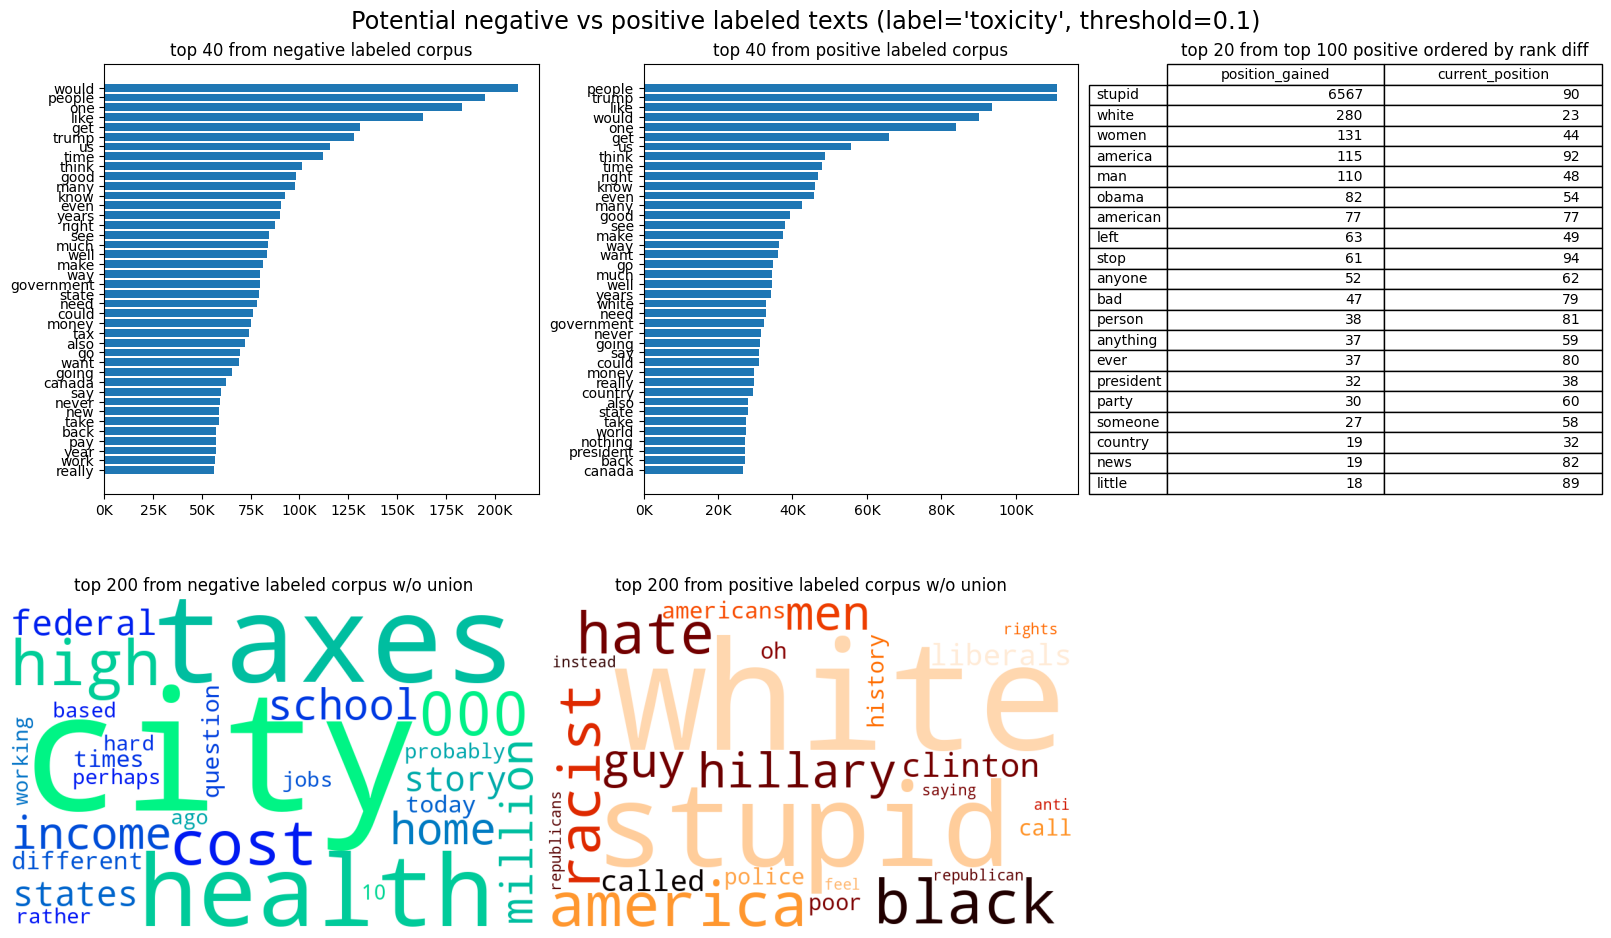

In [ ]:
split_compare(df, tokenized_text_column='comment_text_tokenized', token_sep='$', split_column='toxicity', threshold=0.1)

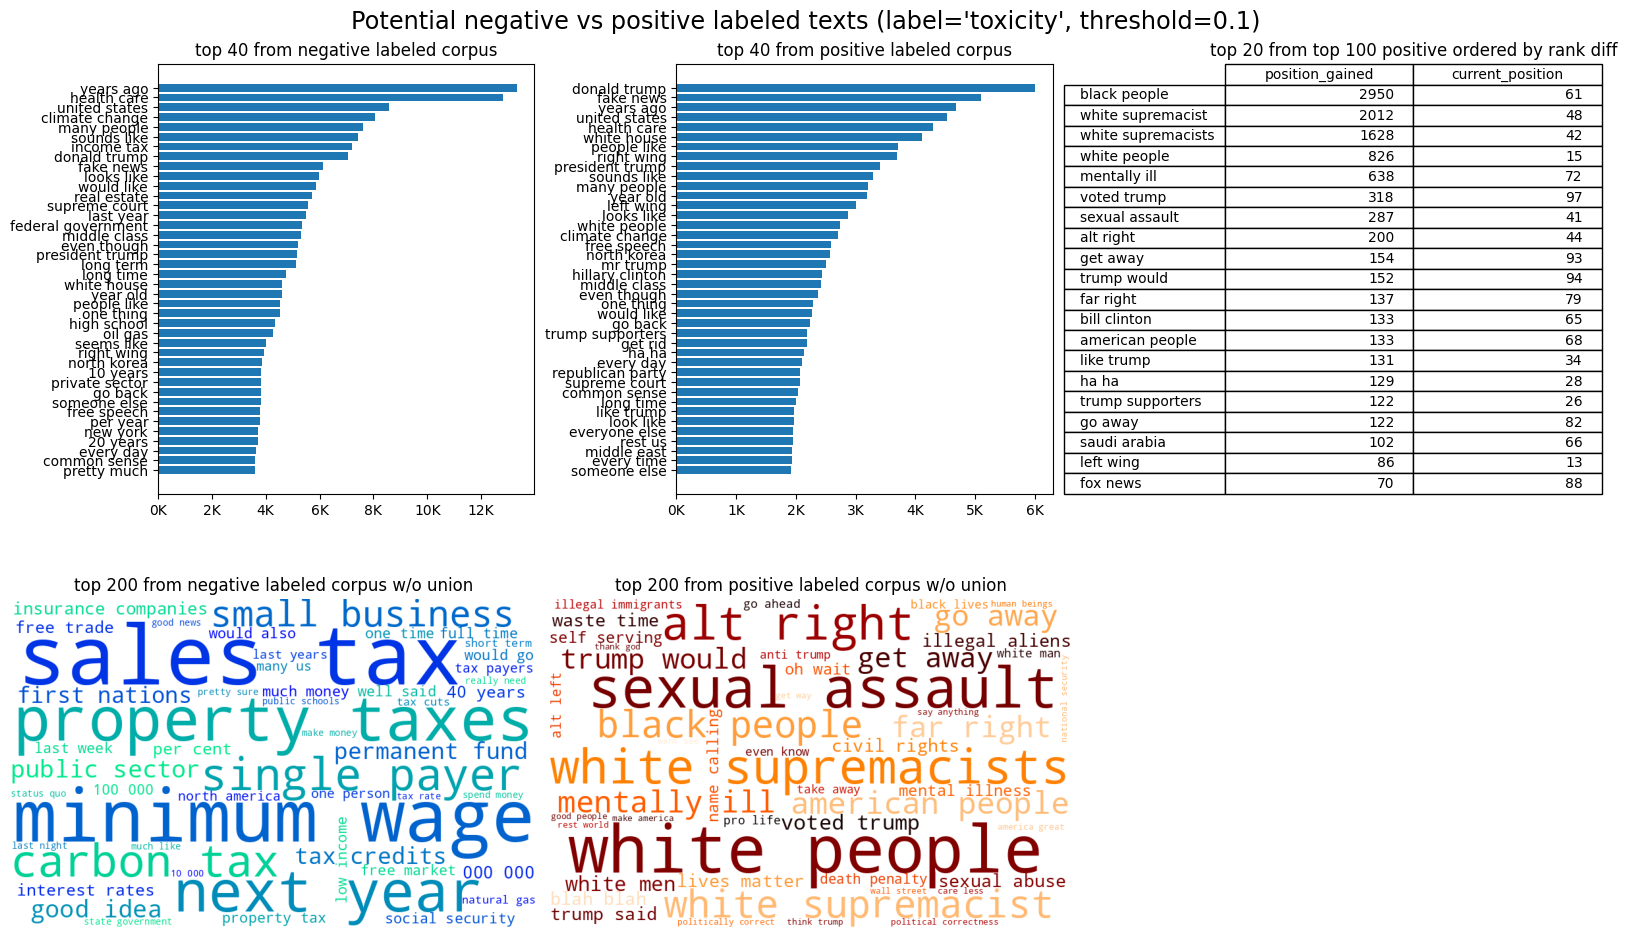

In [ ]:
split_compare(df, tokenized_text_column='comment_text_tokenized', token_sep='$', split_column='toxicity', threshold=0.1, ngram_range=(2, 2))

### Комментарий 0.1

По выборкам:
- в "потенциально не токсичной" выборке признаков токсичности не обнаружено
- в "потенциально токсичной" выборке токсичными показались  3/10 текстов (доли аннотаторов, посчитавших их токсичными, равны 0.6, 0.6 и 0.8)

По графикам:
- в топ 40 токенов и биграмм не наблюдается токсичных ни в потенциально позитивном, ни в негативном классе
- из топ 100 в позитивном классе токен "stupid" больше всего изменяет свою позицию в топе при переходе от нетоксичного к токсичному корпусу и занимает 90 позицию
- по облакам из топ слов без пересечений видно появление потенциально токсичных токенов и биграмм в позитивном классе, однако основую массу составляют относительно нейтральные *Курсив*

In [ ]:
df[df['toxicity'] < 0.2][['toxicity', 'comment_text']].sample(10).style.set_properties(**{'text-align': 'left'})

In [ ]:
df[df['toxicity'] >= 0.2][['toxicity', 'comment_text']].sample(10).style.set_properties(**{'text-align': 'left'})

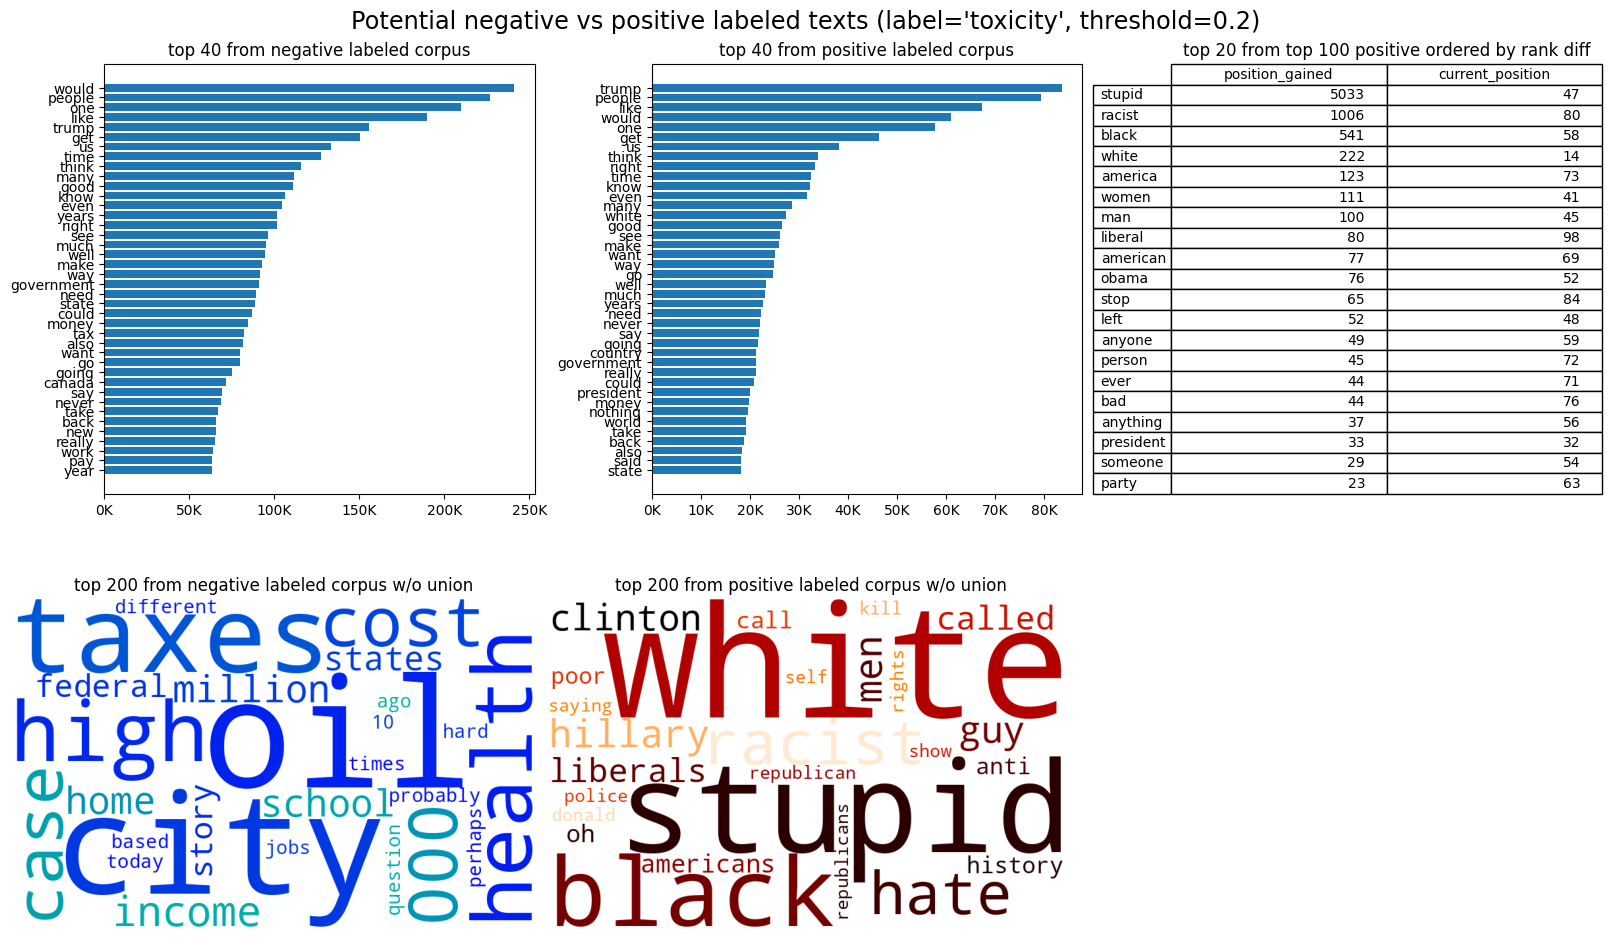

In [ ]:
split_compare(df, tokenized_text_column='comment_text_tokenized', token_sep='$', split_column='toxicity', threshold=0.2)

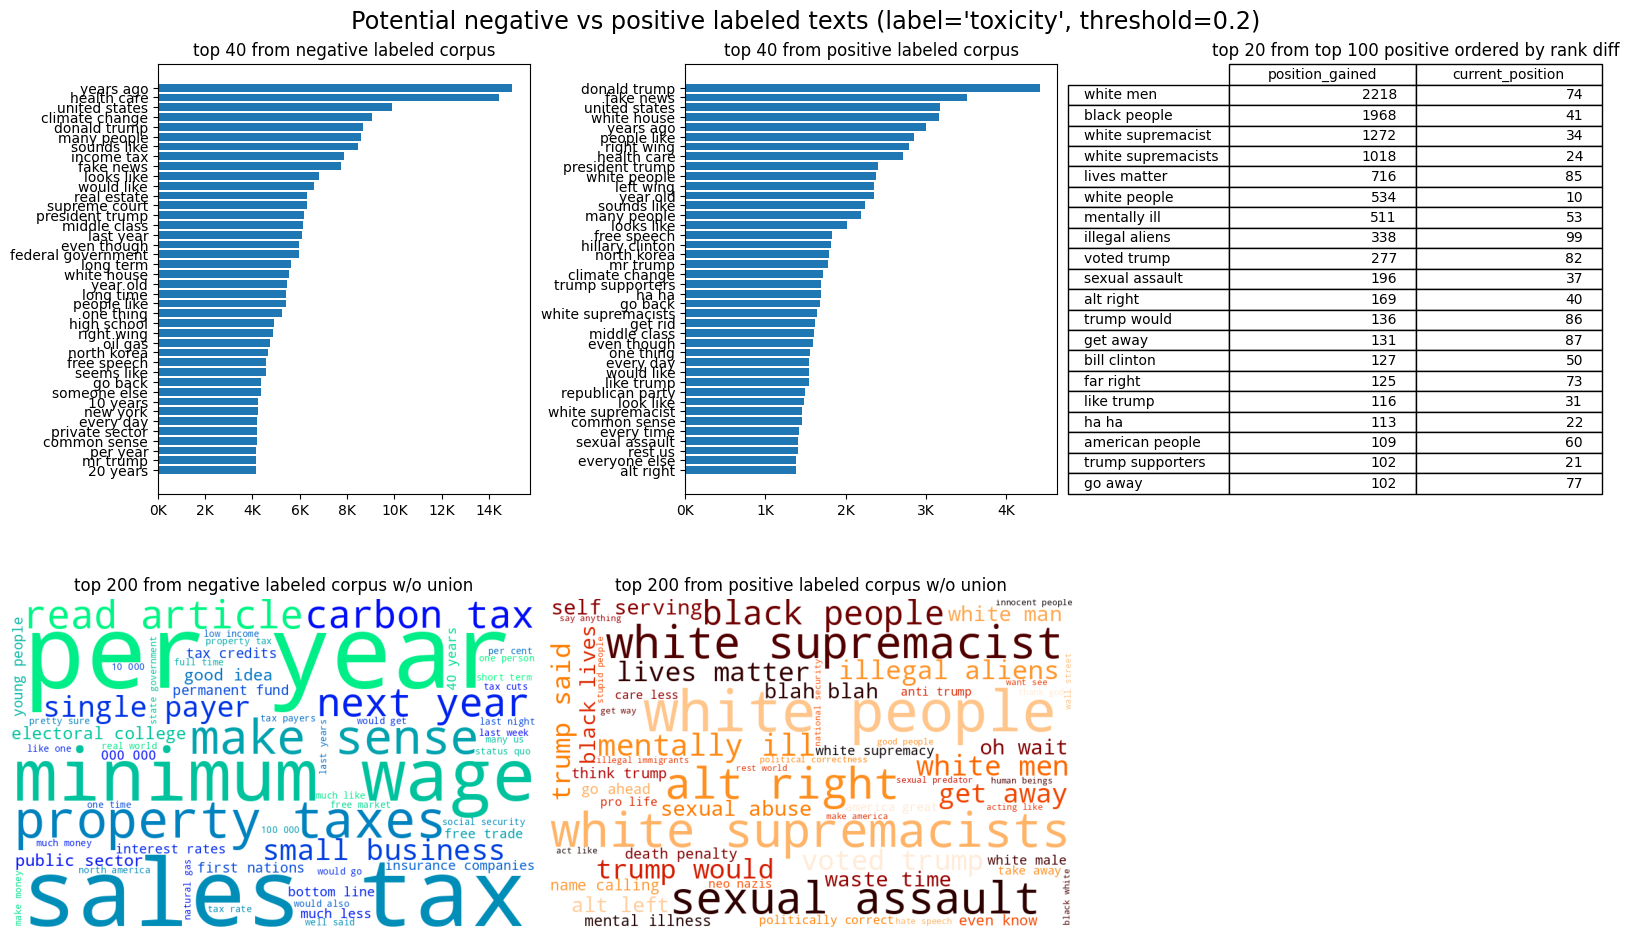

In [ ]:
split_compare(df, tokenized_text_column='comment_text_tokenized', token_sep='$', split_column='toxicity', threshold=0.2, ngram_range=(2, 2))

### Комментарий 0.2

По выборкам:
- в "потенциально не токсичной" выборке признаков токсичности не обнаружено
- в "потенциально токсичной" выборке токсичными показался  1/10 текстов с долей 0.52 (хотя имеются комментарии где доля выше, но они не кажутся токсичными)

По графикам:
- в топ 40 токенов и биграмм не наблюдается токсичных ни в потенциально позитивном, ни в негативном классе
- в топе по изменению позиции к токену "stupid" добавляется токен "racist"
- облака без пересечений стали контрастировать чуть больше

In [ ]:
df[df['toxicity'] < 0.4][['toxicity', 'comment_text']].sample(10).style.set_properties(**{'text-align': 'left'})

In [ ]:
df[df['toxicity'] >= 0.4][['toxicity', 'comment_text']].sample(10).style.set_properties(**{'text-align': 'left'})

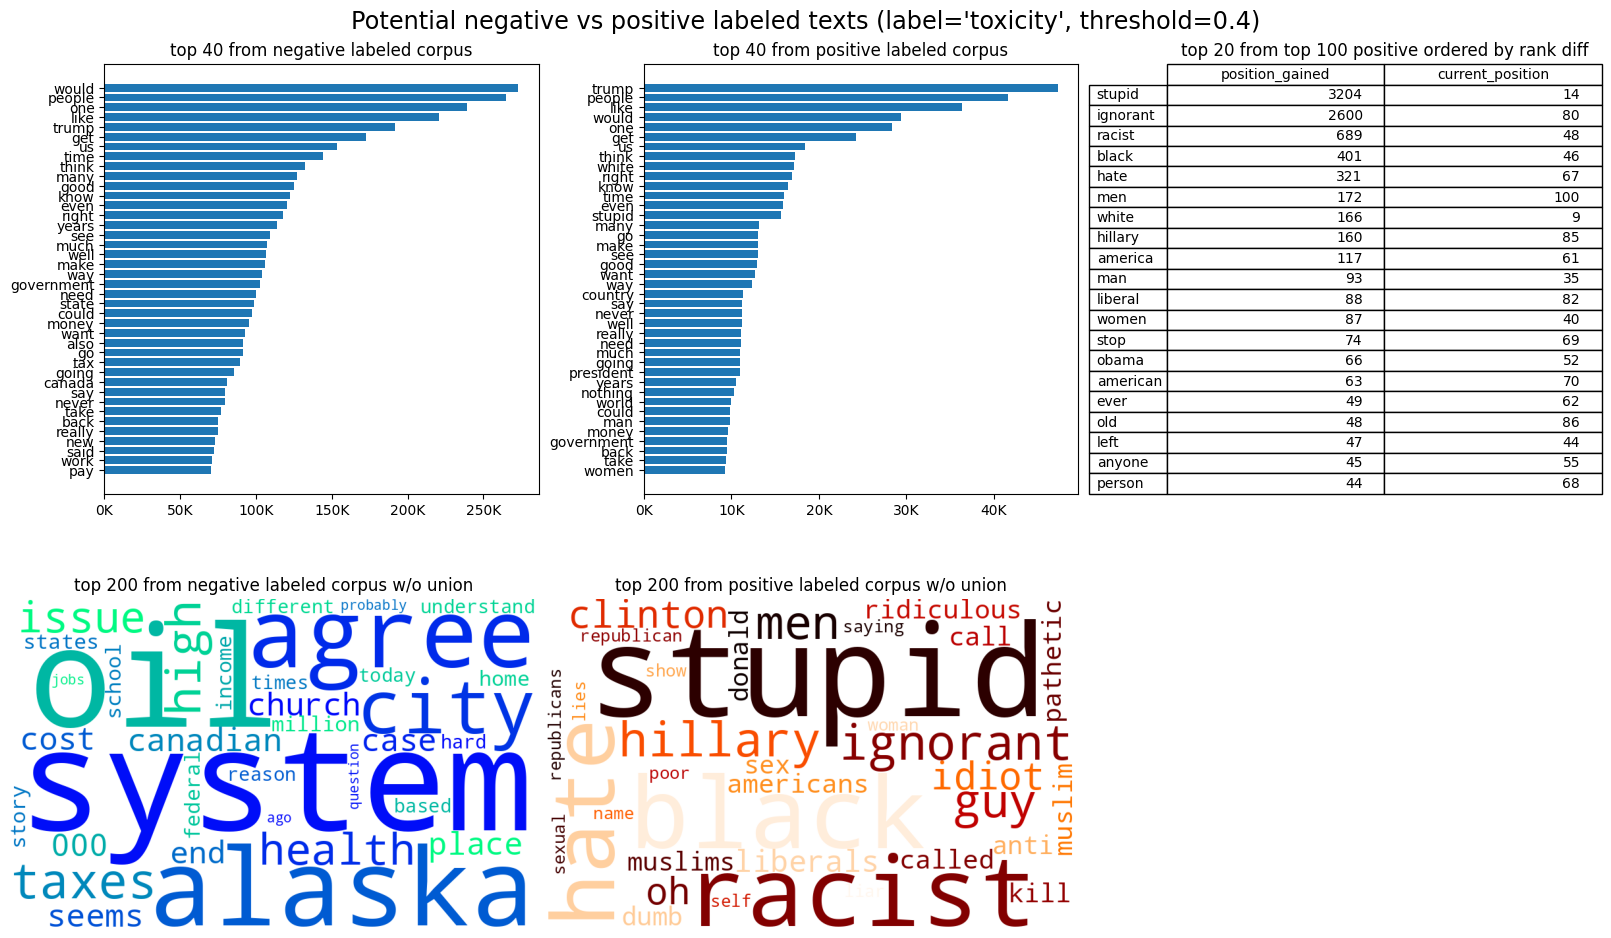

In [ ]:
split_compare(df, tokenized_text_column='comment_text_tokenized', token_sep='$', split_column='toxicity', threshold=0.4)

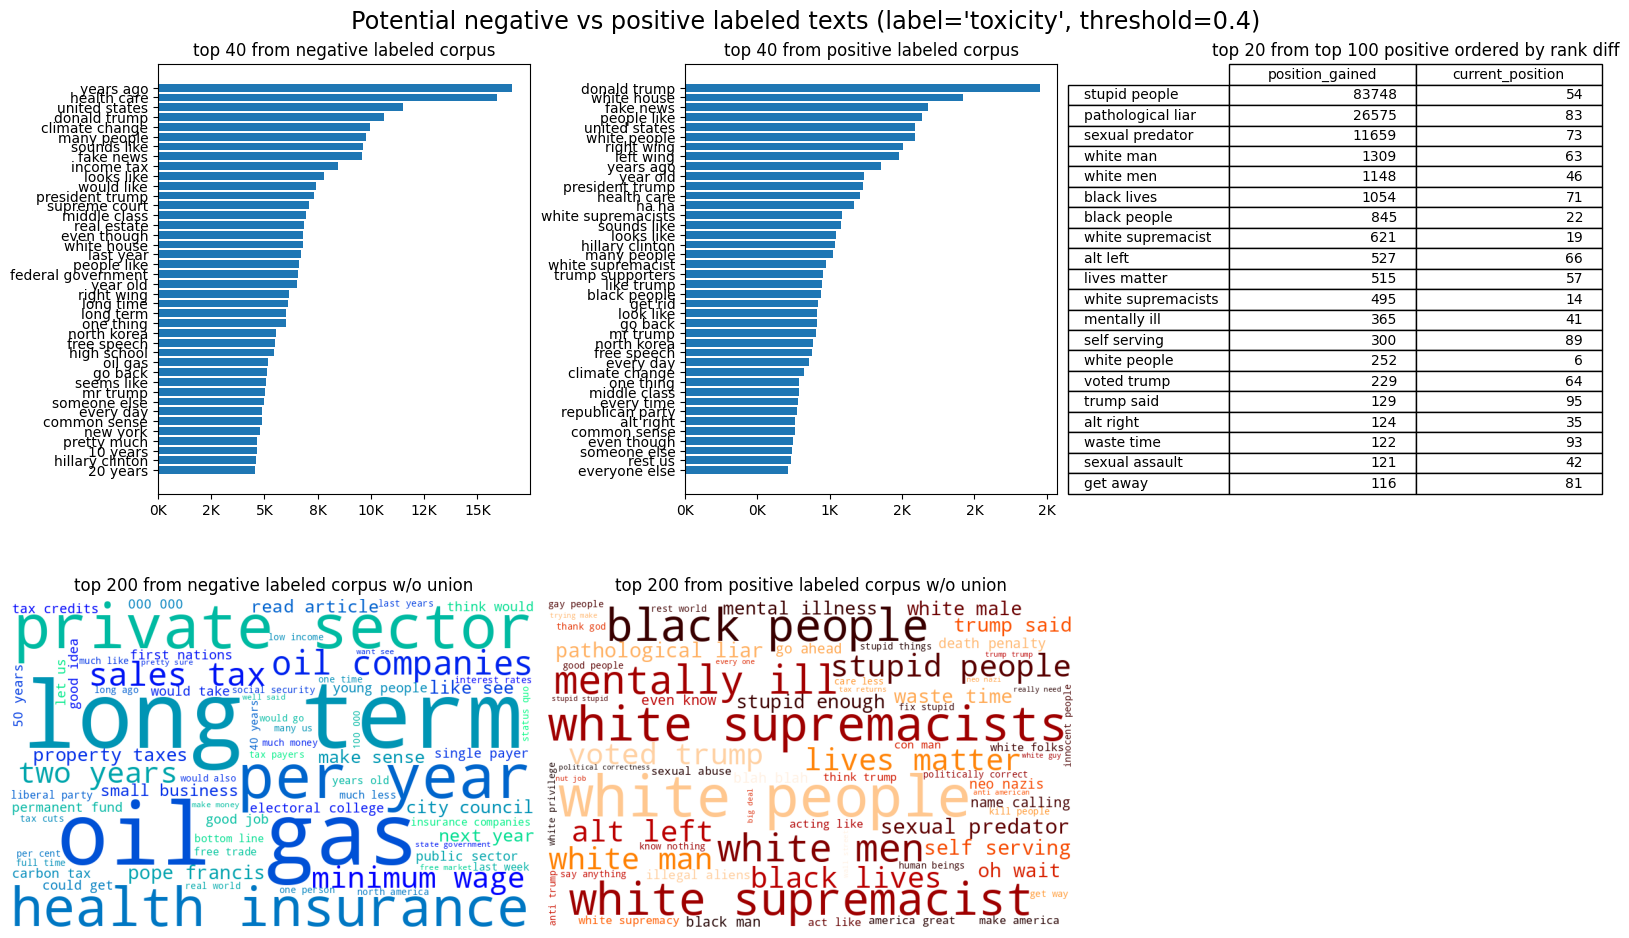

In [ ]:
split_compare(df, tokenized_text_column='comment_text_tokenized', token_sep='$', split_column='toxicity', threshold=0.4, ngram_range=(2, 2))

### Комментарий 0.4

По выборкам:
- в "потенциально не токсичной" выборке признаков токсичности не обнаружено
- в "потенциально токсичной" выборке токсичными показались  7/10 текстов (доли аннотаторов, посчитавших их токсичными, равны 0.78, 0.5, 0.5, 0.66, 0.57, 0.75, 0.4)

По графикам:
- в топ 40 токенов средни потенциально токсичных комментариев появляется токен "stupid"
- в топе по изменению позиции к токенам "stupid" и "racist" добавляется "ignorant", для биграмм в топ выходит "stupid people"
- облака без пересечений стали показывать большее различие между позитивным и негативным классами *Курсив*

In [ ]:
df[df['toxicity'] < 0.5][['toxicity', 'comment_text']].sample(10).style.set_properties(**{'text-align': 'left'})

In [ ]:
df[df['toxicity'] >= 0.5][['toxicity', 'comment_text']].sample(10).style.set_properties(**{'text-align': 'left'})

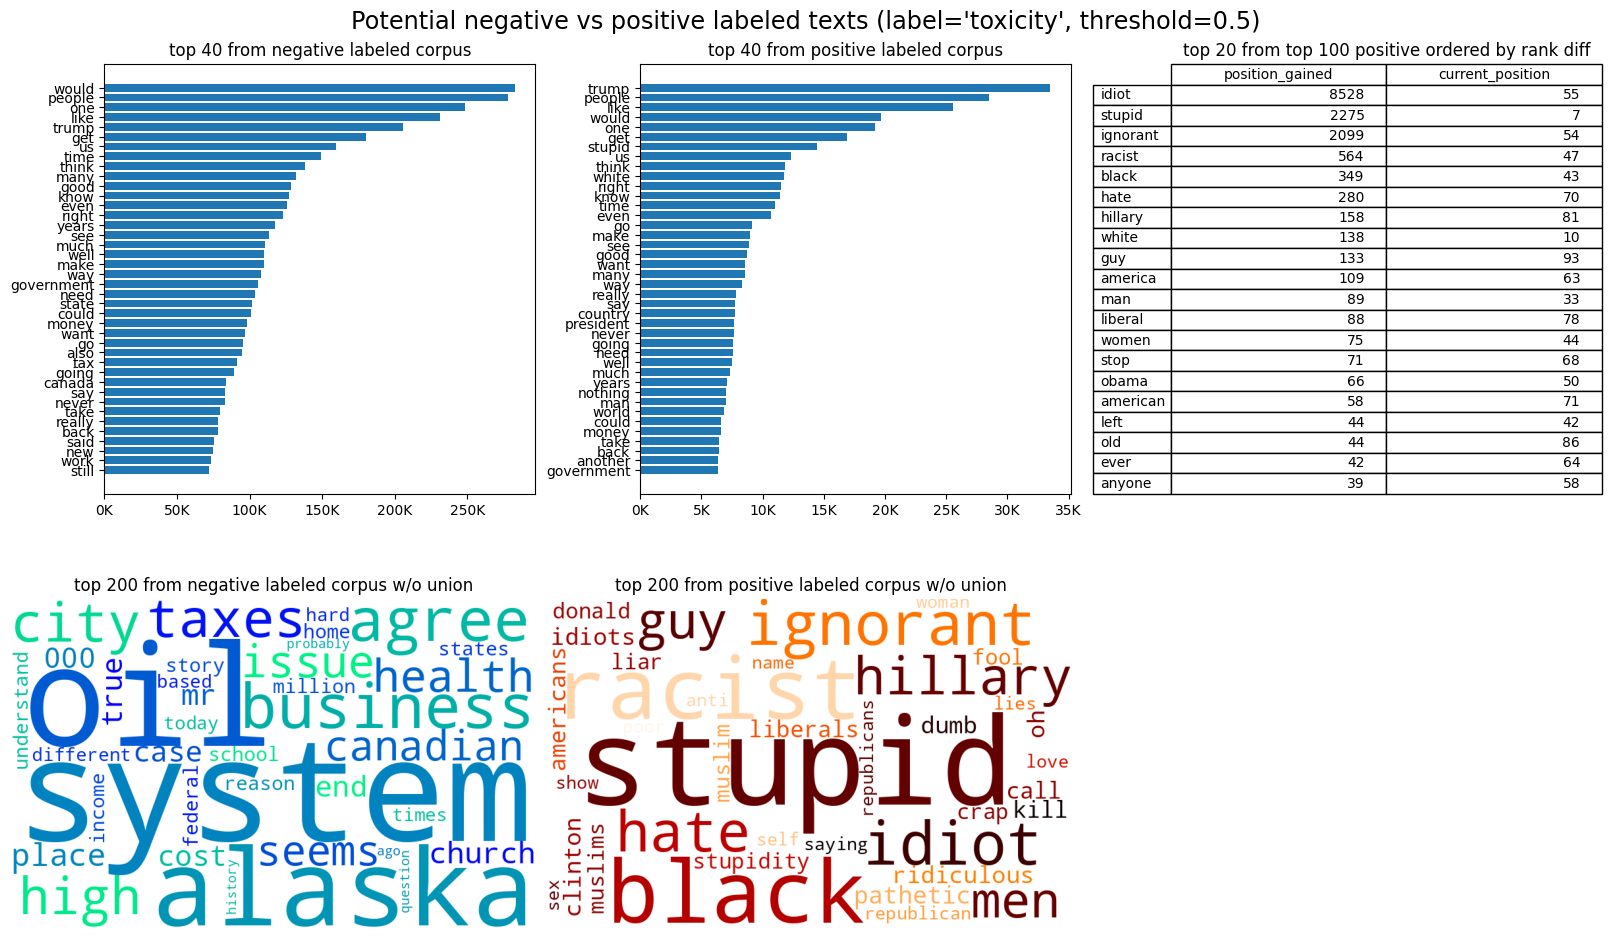

In [ ]:
split_compare(df, tokenized_text_column='comment_text_tokenized', token_sep='$', split_column='toxicity', threshold=0.5)

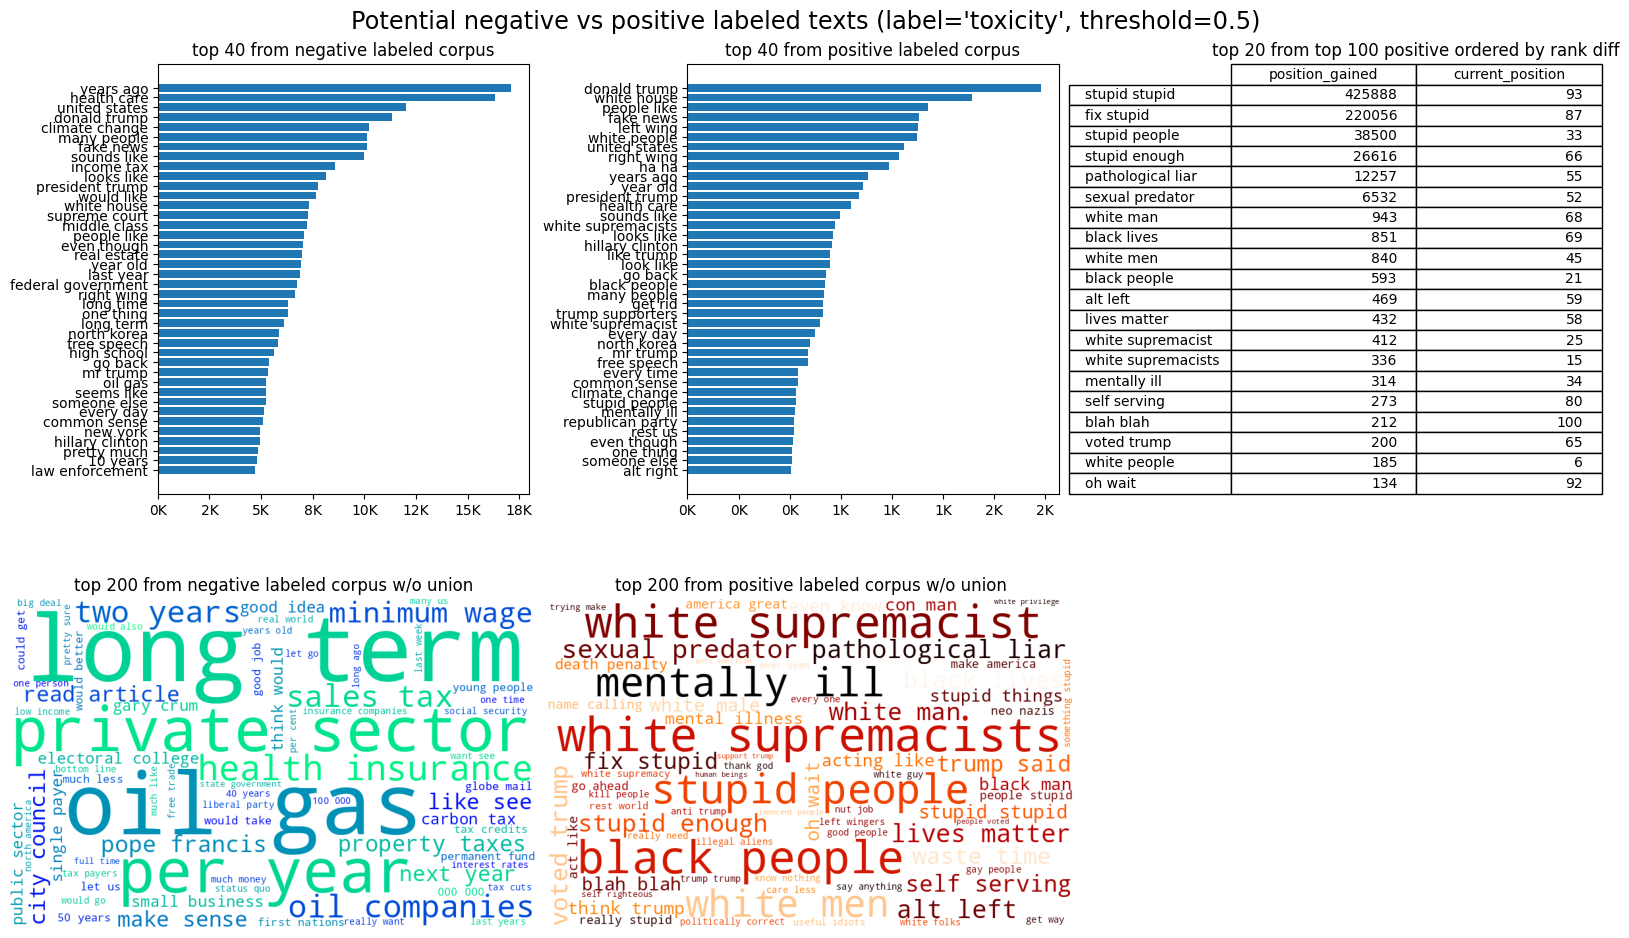

In [ ]:
split_compare(df, tokenized_text_column='comment_text_tokenized', token_sep='$', split_column='toxicity', threshold=0.5, ngram_range=(2, 2))

### Комментарий 0.5

По выборкам:
- в "потенциально не токсичной" 1/10 текстов с долей 0.3 показался токсичным
- в "потенциально токсичной" выборке токсичными показались  8/10 текстов (доли аннотаторов, посчитавших их токсичными, равны 0.5, 0.68, 0.6, 0.75, 0.9, 1, 0.5, 0.5)

По графикам:
- появилось много токсичных биграмм в топе по изменению позиции ("stupid stupid", "fix stupid", "stupid enough", "mentally ill", "blah blah")
- облака без пересечений имеют явно противоположную окраску в контексте токсичности

## Итоговый комментарий

Для значений порога 0.1 и 0.2 различия между negative и positive labeled корпусами просматриваются слабо. Остается выбор из значений 0.4 и 0.5.

На значении 0.4 различия становятся заметными, особенно хорошо видно на облаках слов. В текстах начинает присутствовать сарказм, резко негативные оценочные суждения, большое количество пунктуации (многоточия, вопросительные знаки).

При разделении с порогом 0.5 в текстах появляется явная агрессия, оскорбления, предыдущий тренд усиливается.

Итог: кажется, что для того, чтобы детектировать менее явные проявления токсичности (не связанные с прямой агрессией), для определения меток классов стоит рассмотреть порог $t=0.4$. Им и будем пользоваться в дальнейшем.